In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import torchvision.transforms.v2 as v2
from dl_toolbox import datamodules
from pathlib import Path
from dl_toolbox.utils import show_detections, show_segmentations, show_classifications

/d/pfournie/dl_toolbox/venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### FLAIR

Processing domains


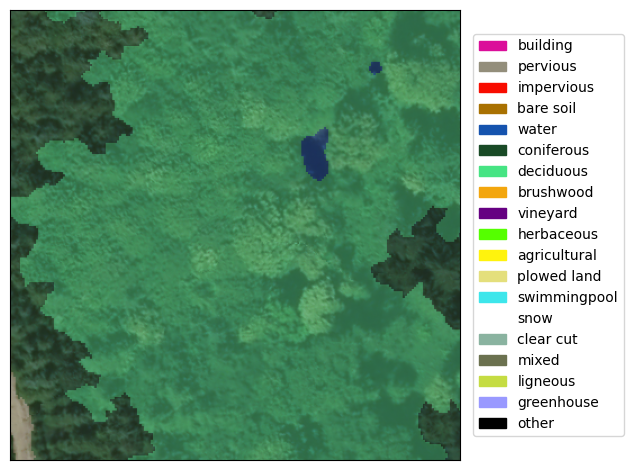

In [2]:
tf = v2.Compose(
    [
        v2.RandomCrop(400),
    ]
)

flair = datamodules.Flair(
    data_path='/data',
    merge='all19',
    bands=[1,2,3],
    train_tf=tf,
    test_tf=tf,
    batch_size=1,
    num_workers=0,
    pin_memory=False
)
flair.setup(stage='fit')
for batch in flair.val_dataloader():
    show_segmentations(batch['image'], batch['target'], classes=flair.class_list, alpha=0.4)
    break

### PSEUDOSUP FLAIR

In [ ]:
%load_ext autoreload
%autoreload 2  

from dl_toolbox.datamodules import FlairPseudosup
import dl_toolbox.transforms as tf
from pathlib import Path
import torch

pl_dir = Path('/data/outputs/flair2_3_97/supervised_dummy/2023-09-05_102306/checkpoints/last_preds')  

dm = FlairPseudosup(
    data_path='/data',
    merge='hierarchical6',
    sup=3,
    unsup=0,
    bands=[1,2,3],
    dataset_tf=tf.To_0_1([0]*3, [255]*3),
    batch_size=4,
    num_workers=4,
    pin_memory=False,
    pl_dir=pl_dir,
    thresh=10
)

show_datamodule(dm, 'sup')

### Digitanie

In [ ]:
%load_ext autoreload
%autoreload 2  
%matplotlib inline
import dl_toolbox.datamodules as datamodules
import dl_toolbox.transforms as tf
import matplotlib.pyplot as plt
from dl_toolbox.utils import labels_to_rgb 
from functools import partial
from pathlib import Path
import rasterio

data = '/work/AI4GEO/data/DATA/DATASETS'
data = '/data'
#t = Path(data)/'DIGITANIE_v4/ARCACHON/ARCACHON_20180821_T_16bits_COG.tif'
#with rasterio.open(t) as f:
#    print(list(f.block_windows())[:10])

dm = datamodules.Digitanie(
    city='TOULOUSE',
    data_path=data,
    merge='main5',
    bands=[1,2,3],
    #dataset_tf=tf.StretchToMinmax([0]*3, [3000]*3),
    sup=4,
    unsup=1,
    #train_tf=partial(
    #    tf.NormalizeFromNpy,
    #    npy=data+'/DIGITANIE_v4/normalisation_stats.npy',
    #    min_p='2',
    #    max_p='995',
    #    bands=[1,2,3]
    #),
    to_0_1=tf.To_0_1([0]*3, [3000]*3),
    train_tf=tf.NoOp(),
    test_tf=tf.NoOp(),
    batch_size_s=4,
    batch_size_u=4,
    steps_per_epoch=250,
    num_workers=0,
    pin_memory=False
)
dm.prepare_data()
dm.setup(stage='fit')
print(len(dm.train_s_set))

dl = dm.train_dataloader()
for i, batch in enumerate(dl):
    batch_type='unsup'
    batch = batch[batch_type]
    for j in range(2):
        f, ax = plt.subplots(ncols=2, figsize=(20,12))
        ax[0].imshow(batch['image'][j].numpy().transpose(1,2,0)[...,:3])
        #ax[0].set_title(batch['image_path'][j])
        if batch_type=='sup':
            ax[1].imshow(labels_to_rgb(batch['label'][j].numpy(),dm.class_colors))
            #ax[1].set_title(batch['label_path'][j])
    plt.show()  
    break

In [ ]:
%timeit

### Digi semisup

In [ ]:
%load_ext autoreload
%autoreload 2  

dm = datamodules.DigitanieCitySemisup(
    data_path='/work/AI4GEO/data/DATA/DATASETS',
    city='TOULOUSE',
    sup=80,
    unsup=1,
    merge='all9',
    bands=[1,2,3],
    dataset_tf=tf.StretchToMinmax([0]*3, [8000.]*3),
    batch_size=4,
    num_workers=0,
    pin_memory=False
)

show_datamodule(dm, 'sup')
show_datamodule(dm, 'unsup')

### RESISC

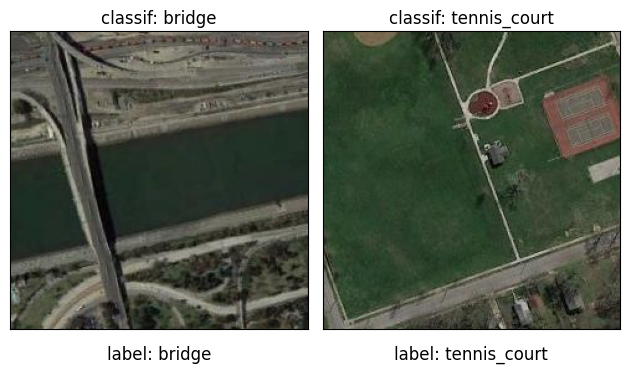

In [2]:
tf = v2.Compose(
    [
        v2.CenterCrop(240),
    ]
)

resisc = datamodules.Resisc(
    #data_path='/work/AI4GEO/users/fournip',
    #data_path='/scratchm/pfournie/data',
    data_path='/data',
    merge='all45',
    train_tf=tf,
    test_tf=tf,
    batch_size=2,
    num_workers=0,
    pin_memory=False
)

resisc.setup(stage='fit')

for batch in resisc.val_dataloader():
    fig = show_classifications(batch['image'], batch['target'], class_list=resisc.class_list)
    break

### Pseudosup resisc

In [ ]:
%load_ext autoreload
%autoreload 2  

from dl_toolbox.datamodules import ResiscPseudosup
import dl_toolbox.transforms as tf

  
dm = ResiscPseudosup(
    data_path='/data',
    merge='all45',
    sup=3,
    unsup=0,
    dataset_tf=tf.StretchToMinmax([0]*3, [255.]*3),
    batch_size=4,
    num_workers=4,
    pin_memory=False,
    pl_dir='/data/outputs/resisc_3_80/sup/2023-09-05_154623/checkpoints/last_preds',
    thresh=4000
)

dm.prepare_data()
dm.setup(stage='fit')

train_dl = dm.train_dataloader()
val_dl = dm.val_dataloader()

%matplotlib inline
import matplotlib.pyplot as plt
from dl_toolbox.utils import labels_to_rgb

for i, batch in enumerate(train_dl):
    batch = batch['pseudosup']
    for j in range(4):
        f, ax = plt.subplots(ncols=1, figsize=(6,6))
        ax.imshow(batch['image'][j].numpy().transpose(1,2,0))
        ax.set_title(batch['label'][j])
    plt.show()  
    break

### Semcity

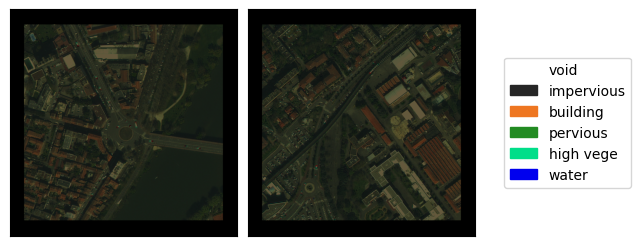

In [3]:
tf = v2.Compose(
    [
        v2.CenterCrop(1000),
    ]
)
    
semcity = datamodules.Semcity(
    data_path="/data",
    merge='main5',
    bands=[1,2,3],
    train_tf=tf,
    test_tf=tf,
    batch_size=2,
    num_workers=0,
    pin_memory=False
)

semcity.setup(stage='fit')

for batch in semcity.val_dataloader():
    show_segmentations(batch['image'], batch['target'], class_list=semcity.class_list, alpha=0.)
    break

### Semcity Pseudosup not implemented

### AIRS

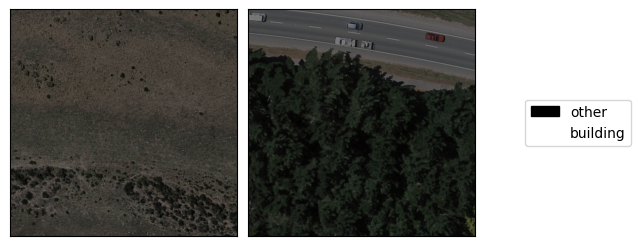

In [5]:
tf = v2.Compose(
    [
        v2.CenterCrop(768),
    ]
)

airs = datamodules.Airs(
    data_path='/data',
    filter_path='/data/AIRS/train.csv',
    merge='building',
    bands=[1,2,3],
    train_tf=tf,
    test_tf=tf,
    batch_size=2,
    num_workers=0,
    pin_memory=False
)

airs.setup(stage='fit')

for batch in airs.val_dataloader():
    show_segmentations(batch['image'], batch['target'], classes=airs.class_list, alpha=0.5)
    break

### CITYSCAPES

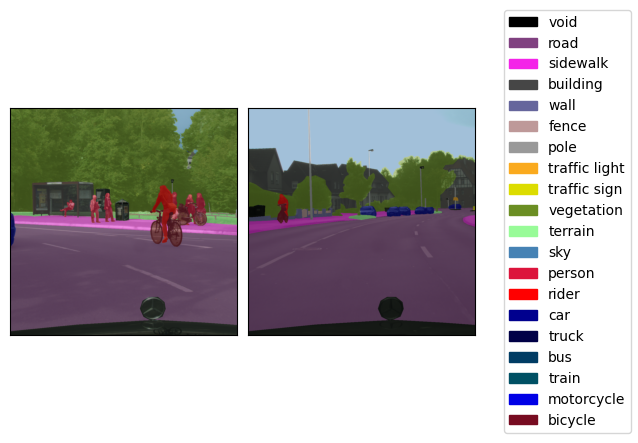

In [3]:
tf = v2.Compose(
    [
        v2.CenterCrop(1000),
    ]
)
  
cityscapes = datamodules.Cityscapes(
    data_path='/data',
    merge='all19',
    train_tf=tf,
    test_tf=tf,
    batch_size=2,
    num_workers=0,
    pin_memory=False
)

cityscapes.setup(stage='fit')

for batch in cityscapes.val_dataloader():
    show_segmentations(batch['image'], batch['target'], class_list=cityscapes.class_list, alpha=0.5)
    break


### Rellis-3D

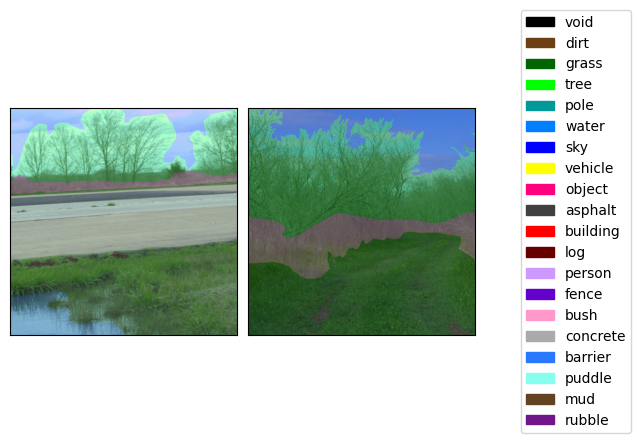

In [3]:
tf = v2.Compose(
    [
        v2.CenterCrop(1000),
    ]
)


    
rellis = datamodules.Rellis(
    data_path='/data',
    merge='all20',
    train_tf=tf,
    test_tf=tf,
    batch_tf=None,
    batch_size=2,
    num_workers=0,
    pin_memory=False
)

rellis.setup(stage='fit')

for batch in rellis.val_dataloader():
    show_segmentations(batch['image'], batch['target'], class_list=rellis.class_list, alpha=0.2)
    break


### xView

Seed set to 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
loading annotations into memory...
Done (t=2.85s)
creating index...
index created!
loading annotations into memory...
Done (t=3.05s)
creating index...
index created!


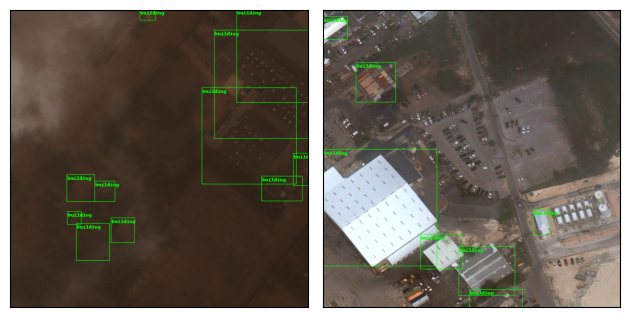

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import dl_toolbox.datamodules as datamodules
from pathlib import Path
import torchvision.transforms.v2 as v2
import torch
from torchvision import tv_tensors
import matplotlib.pyplot as plt
from torchvision.transforms.v2 import functional as F
import torchvision.utils as tv_utils
import pytorch_lightning as pl
from dl_toolbox.utils import show_detections

pl.seed_everything(2)

tf = v2.Compose(
    [
        v2.CenterCrop(600),
        v2.SanitizeBoundingBoxes(),
    ]
)
 
dm = datamodules.xView(
    data_path='/data',
    merge='building',
    train_tf=tf,
    test_tf=tf,
    batch_size=2,
    num_workers=0,
    pin_memory=False
)

dm.setup(stage='fit')

for batch in dm.val_dataloader():
    show_detections(batch['image'], batch['target'], class_list=dm.class_list)
    break

### COCO

In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import dl_toolbox.datamodules as datamodules
from pathlib import Path
import torchvision.transforms.v2 as v2
import torch
from torchvision import tv_tensors
import matplotlib.pyplot as plt
from torchvision.transforms.v2 import functional as F
import torchvision.utils as tv_utils


tf = v2.Compose(
    [
        v2.Resize(size=480, max_size=640),
        v2.RandomCrop(size=(640,640), pad_if_needed=True, fill=0),
        v2.SanitizeBoundingBoxes(),
        #v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]
)

dm = datamodules.Coco(
    data_path='/data',
    merge='all',
    train_tf=tf,
    test_tf=tf,
    batch_size=2,
    num_workers=0,
    pin_memory=False
)

dm.setup(stage='fit')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
loading annotations into memory...
Done (t=10.47s)
creating index...
index created!
loading annotations into memory...
Done (t=0.35s)
creating index...
index created!
loading annotations into memory...
Done (t=0.30s)
creating index...
index created!


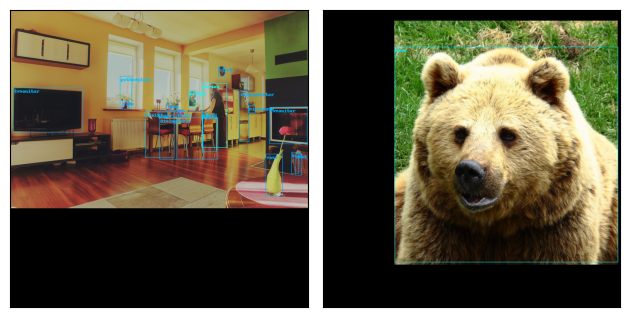

In [5]:
for batch in dm.val_dataloader():
    show_detections(batch['image'], batch['target'], class_list=dm.class_list)
    break